# Top Vendors

Due to the high number of vendors, and the probable dependency between some of them, it is beneficial to reduce this number. To accomplish this we analyse the malware in duplicated samples and check for vendors that correctly classified samples as malware in the first submission.

In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

malware_threshold = 5
data_folder = '../data/'
vendors_file = data_folder + 'vendors.csv.gz'
reports_file = data_folder + 'reports.csv.gz'

In [2]:
# Contains all header information
reports = pd.read_csv(reports_file)
reports = reports.set_index('link')
# Sanity check
assert len(reports[~reports.file_type.str.startswith('PE32')]) == 0
reports.drop(['file_name', 'file_size', 'file_type'], axis=1, inplace=True)
reports.date = pd.to_datetime(reports.date, infer_datetime_format=True)
# Now it contains:
# reports = (link, md5, date)

# Contains link as vendors classification
vendors = pd.read_csv(vendors_file, dtype=str)
vendors = vendors.set_index('link')
vendors.dropna(how='all', inplace=True)

# Joins on link
# reports_vendors = (link, md5, date, ..vendors..)
reports_vendors = reports.join(vendors, how='inner')

## High presence vendors

Before filtering for detection rate, we reduce the number of vendors by filtering only those who classify at least 90% of the dataset (of classified samples by all).

In [3]:
vendors_presence = vendors.count()/len(vendors)
majority_vendors = list(vendors_presence[vendors_presence >= 0.9].index)

In [4]:
# Keep just the high vendors
reports_vendors = reports_vendors[['date', 'md5'] + majority_vendors]

## Top vendors

To calculate the detection rate (TPR) and FPR we take the last submission of every sample as the baseline. Hence if a sample as 5+ positive classifications or 0 positive classifications it is marked as malware or goodware, respectively.

### Duplicated samples

In [5]:
# MD5 of duplicated samples
md5_dups = set(reports_vendors[reports_vendors.md5.duplicated()].md5)

#### Malware samples

In [6]:
# Get samples that are malware (5+ classifications) by the last submission
malware_last = reports_vendors[reports_vendors.md5.isin(md5_dups)].sort_values('date').drop_duplicates(keep='last', subset='md5')
malware_last.replace('Clean', np.nan, inplace=True)
# +2 because of date and md5 columns
malware_last = malware_last[malware_last.count(axis=1) >= malware_threshold + 2]

#### Goodware samples

In [7]:
# Get samples that are goodware (0 classifications) by the last submission
goodware_last = reports_vendors[reports_vendors.md5.isin(md5_dups)].sort_values('date').drop_duplicates(keep='last', subset='md5')
goodware_last.replace('Clean', np.nan, inplace=True)
# 2 because of date and md5 columns
goodware_last = goodware_last[goodware_last.count(axis=1) == 2]

### Detection Rate/True Positive Rate

In [8]:
# Get the first submission of the previous samples
malware_first = reports_vendors[reports_vendors.md5.isin(malware_last.md5)].sort_values('date').drop_duplicates(keep='first', subset='md5')
malware_first.replace('Clean', np.nan, inplace=True)
# Remove md5 and date column
malware_first.drop(labels=['md5', 'date'], axis=1, inplace=True)

#### Calculated detection rate in the first submission

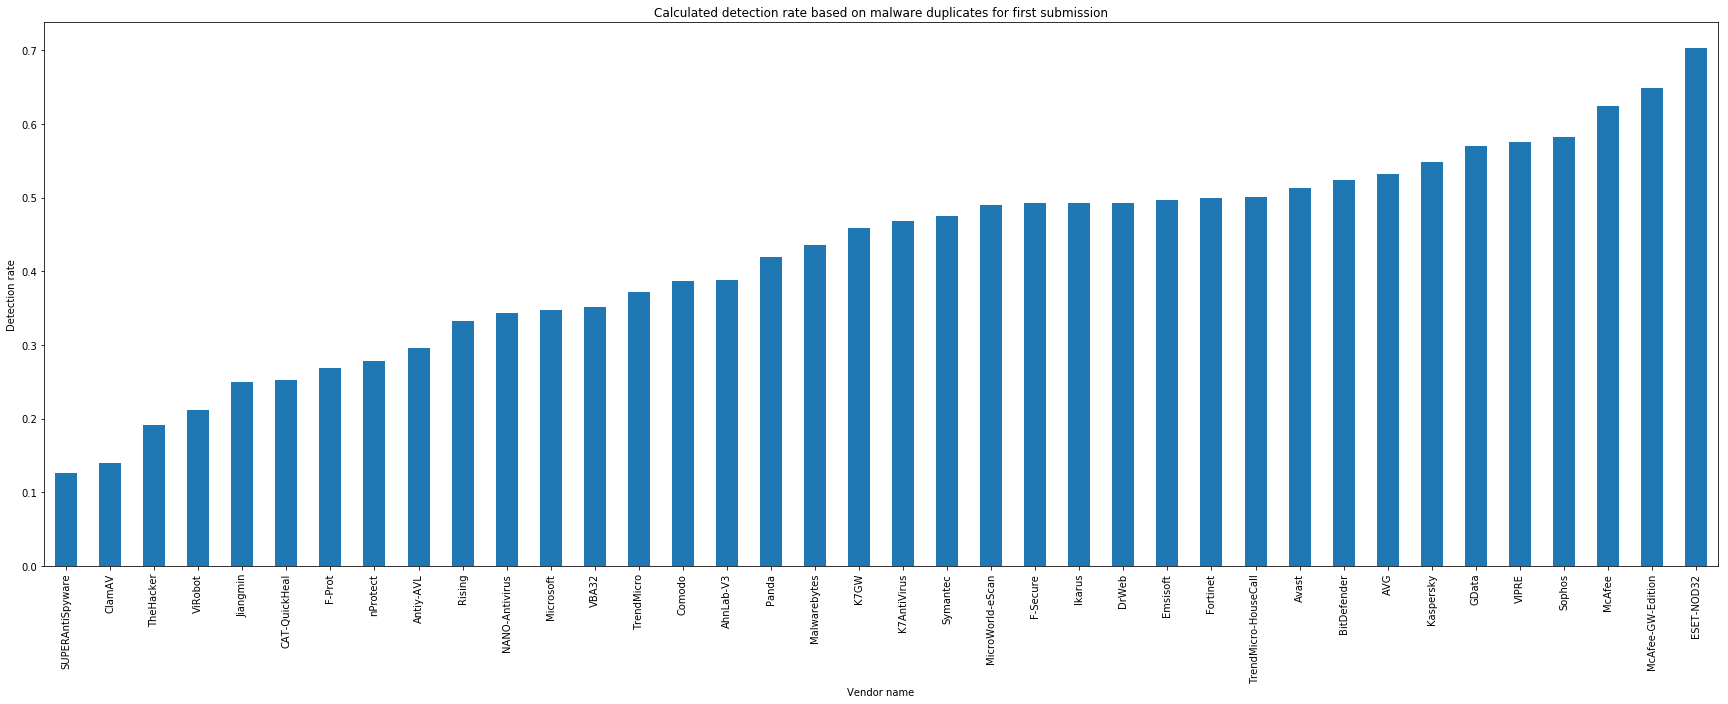

In [9]:
# Calculate the detection rate in the first submission
first_dr = malware_first.count()/len(malware_last)
first_dr.sort_values(inplace=True)
ax = first_dr.plot.bar(figsize=((30, 10)),
                       title='Calculated detection rate based on malware duplicates for first submission')
ax.set_xlabel('Vendor name')
ax.set_ylabel('Detection rate')
plt.show()

#### Calculated detection rate in the last submission

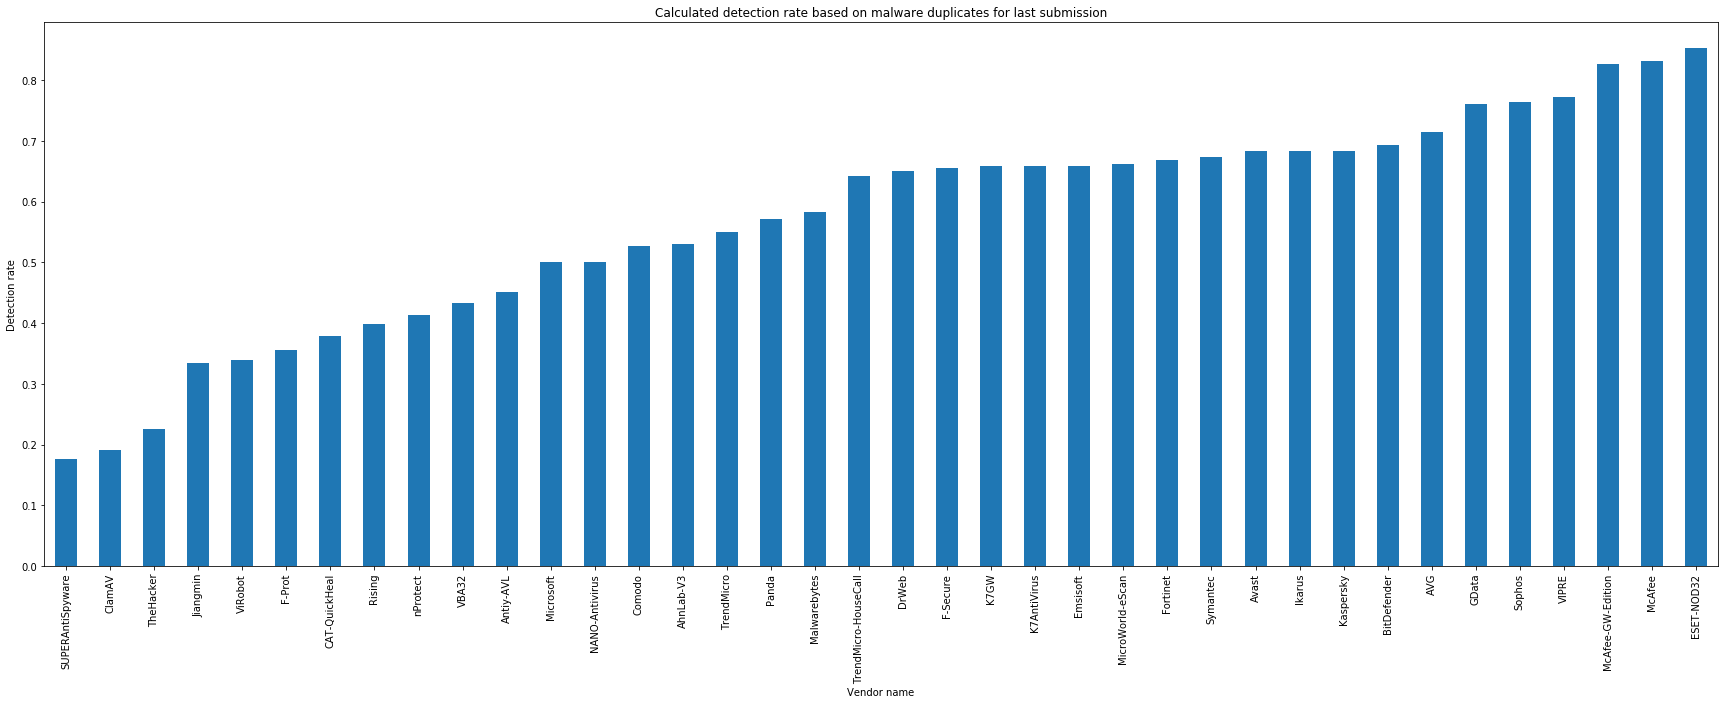

In [10]:
# Calculate the detection rate in the last submission
last_dr = malware_last.drop(labels=['md5', 'date'], axis=1).count()/len(malware_last)
last_dr.sort_values(inplace=True)
ax = last_dr.plot.bar(figsize=((30, 10)),
                       title='Calculated detection rate based on malware duplicates for last submission')
ax.set_xlabel('Vendor name')
ax.set_ylabel('Detection rate')
plt.show()

#### Calculated detection rate in the first and last submission

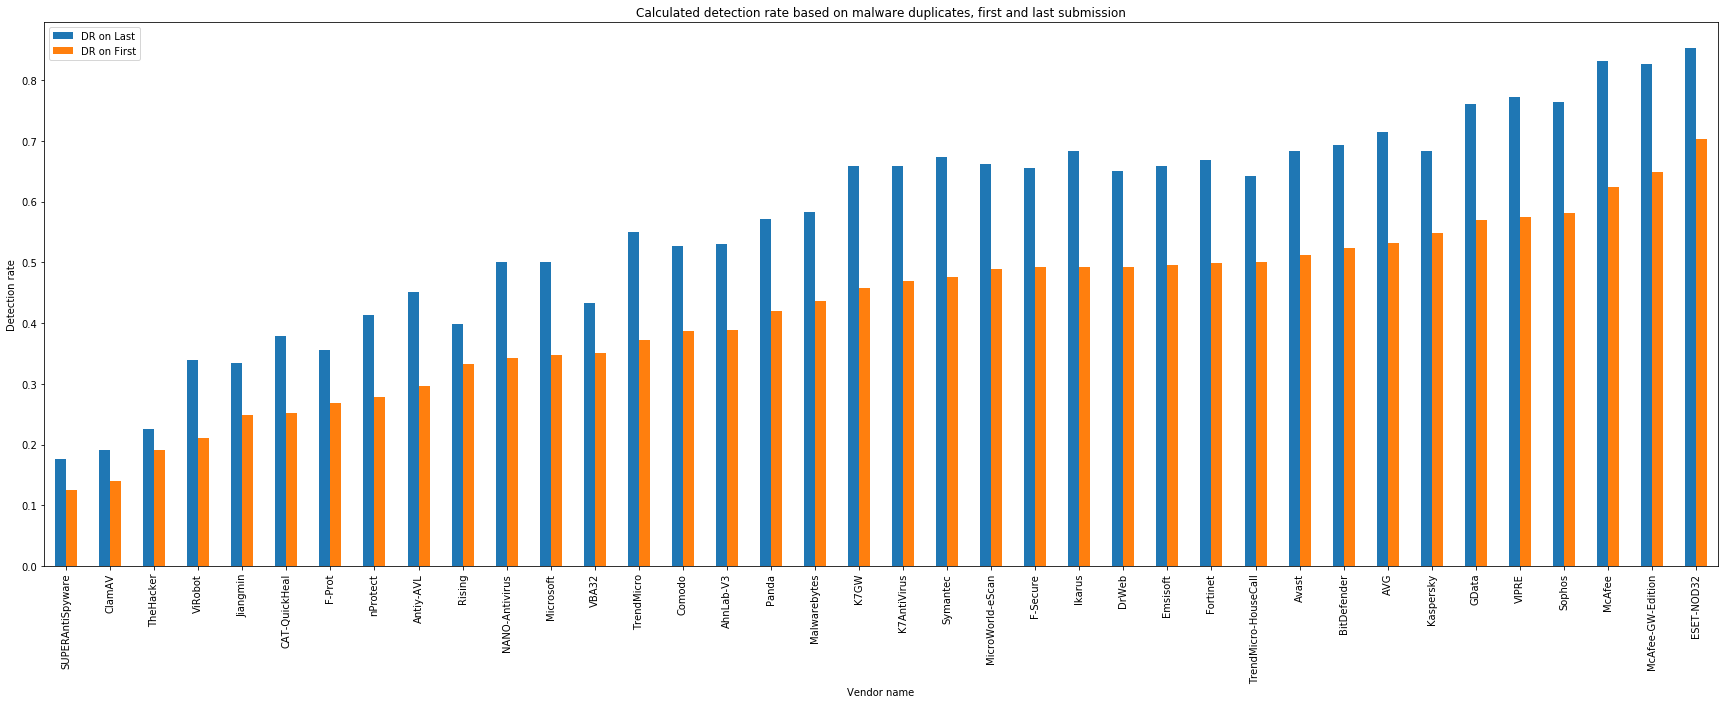

'Top 20 vendors calculated detection rate in both first and last submission:'

,DR on Last,DR on First
ESET-NOD32,0.852428,0.702634
McAfee-GW-Edition,0.826601,0.649277
McAfee,0.831043,0.624845
Sophos,0.763378,0.581870
VIPRE,0.771539,0.575155
GData,0.761364,0.570610
Kaspersky,0.684091,0.548140
AVG,0.714773,0.532231
BitDefender,0.693802,0.524483
Avast,0.682800,0.512500


In [11]:
first_last_detections = pd.concat([last_dr, first_dr], axis=1)
first_last_detections.columns = ['DR on Last', 'DR on First']
# Filter vendors by top 20
top_vendors = first_last_detections.sort_values('DR on First', ascending=False)[:20]
# top_vendors = first_last_detections[
#     (first_last_detections['DR on First'] >= 0.5) &
#     (first_last_detections['DR on Last'] >=0.5)]
top_vendors.is_copy = False

ax = first_last_detections.sort_values('DR on First').plot.bar(figsize=((30, 10)),
                        title='Calculated detection rate based on malware duplicates, first and last submission')
ax.set_xlabel('Vendor name')
ax.set_ylabel('Detection rate')
plt.show()
display('Top 20 vendors calculated detection rate in both first and last submission:')
display(top_vendors.sort_values('DR on First', ascending=False))

### False Positive Rate

In [12]:
# Get the first submission of the previous samples
goodware_first = reports_vendors[reports_vendors.md5.isin(goodware_last.md5)].sort_values('date').drop_duplicates(keep='first', subset='md5')
goodware_first.replace('Clean', np.nan, inplace=True)
# Remove md5 and date column
goodware_first.drop(labels=['md5', 'date'], axis=1, inplace=True)

#### Calculate FPR for first submission

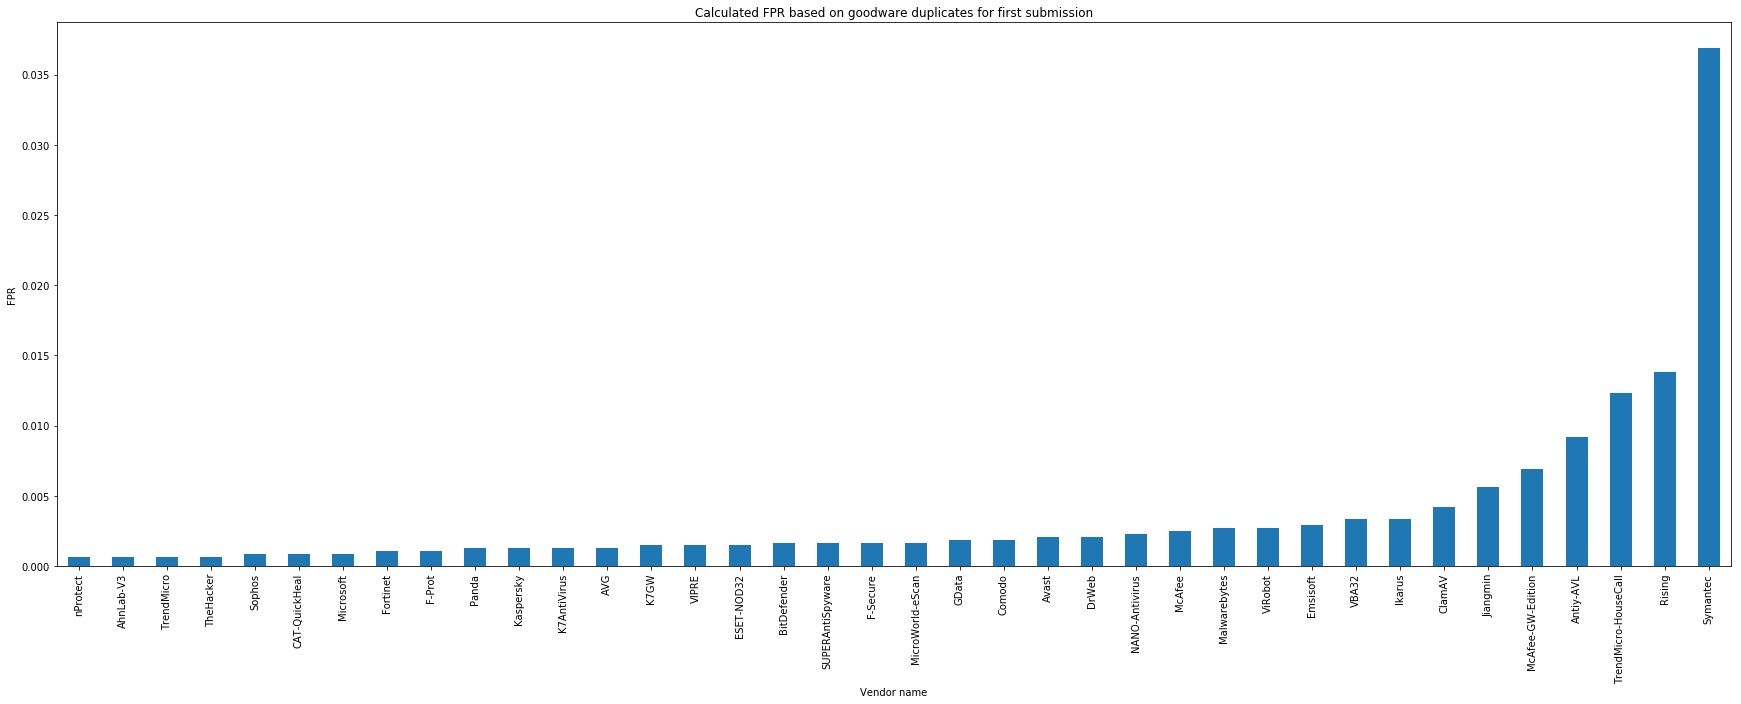

,DR on Last,DR on First,FPR on First
ESET-NOD32,0.852428,0.702634,0.001467
McAfee-GW-Edition,0.826601,0.649277,0.006914
McAfee,0.831043,0.624845,0.002514
Sophos,0.763378,0.581870,0.000838
VIPRE,0.771539,0.575155,0.001467
GData,0.761364,0.570610,0.001886
Kaspersky,0.684091,0.548140,0.001257
AVG,0.714773,0.532231,0.001257
BitDefender,0.693802,0.524483,0.001676
Avast,0.682800,0.512500,0.002095


In [13]:
# Calculate the FPR in the first submission
first_fpr = goodware_first.count()/len(goodware_last)
first_fpr.sort_values(inplace=True)
ax = first_fpr.plot.bar(figsize=((30, 10)),
                       title='Calculated FPR based on goodware duplicates for first submission')
ax.set_xlabel('Vendor name')
ax.set_ylabel('FPR')
plt.show()

temp = pd.DataFrame(first_fpr[top_vendors.index])
temp.columns = ['FPR on First']
top_vendors['FPR on First'] = first_fpr[top_vendors.index]
display(top_vendors.sort_values('DR on First', ascending=False))

### Validate changes in classification

How the classification changes from first to last, same analysis as in notebook 1.

In [14]:
reports_duplicated = reports_vendors[reports_vendors.md5.isin(md5_dups)]
reports_duplicated = reports_duplicated[['date', 'md5'] + list(top_vendors.index)]
reports_duplicated.is_copy = False
vendors_count = reports_duplicated.replace('Clean', np.nan)
vendors_count = vendors_count.groupby(['md5', 'date']).count().sum(axis=1).reset_index('date')

#### Calculate the differences

In [15]:
%%time
differences = []
# For differences in first and last submission
differences_fl = []
# Calculate the pairwise difference between reports
for md5 in vendors_count.index.unique():
    temp = vendors_count[vendors_count.index == md5].sort_values('date', ascending=False)
    count = list(temp[0])
    if sum(count) == 0:
        continue
    differences_fl += [count[0] - count[-1]]
    differences += [x - y for x, y in zip(count, count[1:])]

CPU times: user 4min 53s, sys: 248 ms, total: 4min 53s
Wall time: 4min 53s


In [16]:
differences_count = pd.Series(differences).value_counts().sort_index()
display('{}/{} ({:.2f}%) samples changed classification.'.format(
    differences_count[differences_count.index != 0].sum(),
    differences_count.sum(),
    100*differences_count[differences_count.index != 0].sum()/differences_count.sum()))

'15896/40461 (39.29%) samples changed classification.'

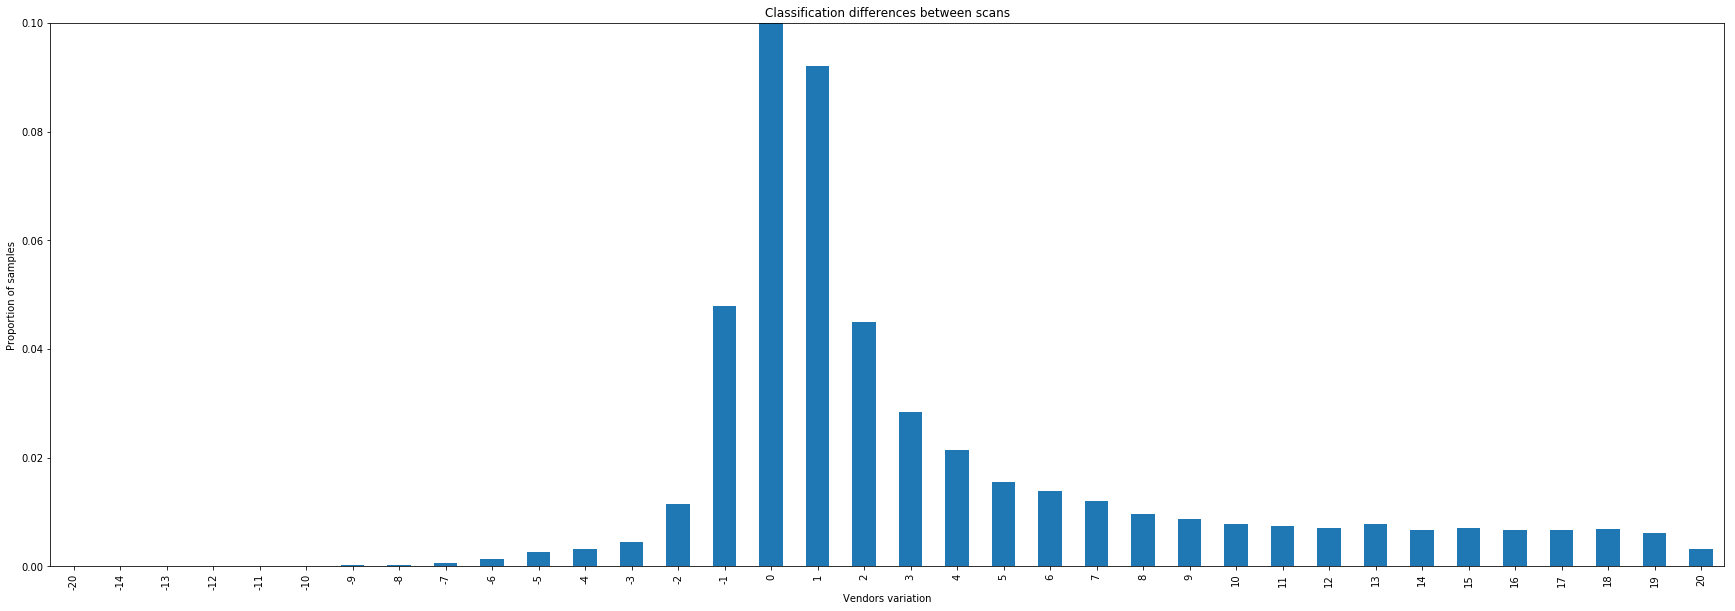

In [17]:
differences_ratio = differences_count.divide(differences_count.sum())
ax = differences_ratio.plot.bar(
    figsize=((30, 10)), title='Classification differences between scans',
    ylim=(0, 0.1))
ax.set_xlabel('Vendors variation')
ax.set_ylabel('Proportion of samples')
plt.show()

In [18]:
display('Samples that increased classification: {:.2f}%'.format(
    differences_ratio[differences_ratio.index > 0].sum()*100))
display('Samples that decreased classification: {:.2f}%'.format(
    differences_ratio[differences_ratio.index < 0].sum()*100))
display('Samples that went from 5 or more vendors to none: {:.2f}%'.format(
    differences_ratio[differences_ratio.index <= -5].sum()*100))
display('Samples that went from 5 or more vendors to one: {:.2f}%'.format(
    differences_ratio[differences_ratio.index <= -4].sum()*100))

'Samples that increased classification: 32.01%'

'Samples that decreased classification: 7.28%'

'Samples that went from 5 or more vendors to none: 0.57%'

'Samples that went from 5 or more vendors to one: 0.89%'

## Conclusion

By filtering vendors that classify at least 90% of the dataset we filtered down the number of vendors. With the remaining vendors we calculated the detection rate (TPR) and false positive rate (FPR), based on changes in duplicated submissions and using the metric of 5+ classifications for malware and 0 classifications for goodware.

The top 20 vendors, based on detection rate were selected and are to be used for labeling the samples as either goodware or malware.